In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
SHAPE = (50,25,5)
walls = np.zeros((SHAPE[0],SHAPE[1]))

# Здесь в массив walls надо будет выгрузить изображение как массив из 0 (можно ходить) и 1 (стенка)
walls[:20,20] = 1.
walls[0,:] = 1.
walls[-1,:] = 1.
walls[:,-1] = 1.
walls[:,0] = 1.

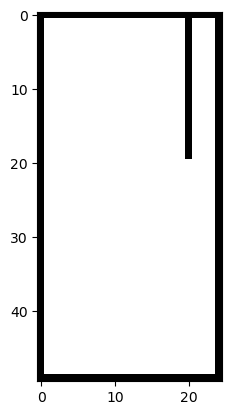

In [3]:
plt.imshow(walls[:,:], cmap = 'Greys')
plt.show()

In [22]:
t_max = 300 #Максимальное время в секундах
dt = 0.1 #Дискретизация по времени
dx = 1. #Буквально 1 метр

#координаты источника
source_coords = [0,23,2] #x,y,z

#интенсивность источника
source_J = 0.1 #kg/m^3/s

#что-то типа коэффициента диффузии
D = 1e-6

In [23]:
den = np.zeros((int(t_max/dt), SHAPE[0],SHAPE[1],SHAPE[2]), dtype = np.float32) #time, x,y,z

In [24]:
#Обратные расстояния от центра куба до его ячеек
cubic = np.array([[[1./np.sqrt(3),1./np.sqrt(2),1./np.sqrt(3)],
                   [1./np.sqrt(2),1.,1./np.sqrt(2)],
                   [1./np.sqrt(3),1./np.sqrt(2),1./np.sqrt(3)]
                  ],
                  [[1./np.sqrt(2),1.,1./np.sqrt(2)],
                   [1.,0.,1.],
                   [1./np.sqrt(2),1.,1./np.sqrt(2)]
                  ],
                  [[1./np.sqrt(3),1./np.sqrt(2),1./np.sqrt(3)],
                   [1./np.sqrt(2),1.,1./np.sqrt(2)],
                   [1./np.sqrt(3),1./np.sqrt(2),1./np.sqrt(3)]
                  ]
                 ])

In [25]:
#Штука, которая считает градиенты по текущему полю плотности
def get_gradients_simple(den_t, walls = walls, sc = source_coords, D=D):
    #Считаем добавки на каждой ячейке
    grads = np.zeros((den_t.shape[0]+2,den_t.shape[1]+2,den_t.shape[2]+2), dtype = np.float32) #немножко паддим, чтобы не было ошибок
    for x,y,z in np.argwhere(den_t > 1e-8):
        grads[1+ (x-1):1+(x+2), 1+(y-1):1+(y+2), 1+(z-1):1+(z+2)] += D*dt*cubic
    
    grads_new = grads[1:-1,1:-1,1:-1]*(1.-np.expand_dims(walls, axis = -1))
    grads = grads_new*np.sum(grads)/np.sum(grads_new)
    
    return grads

In [26]:
# Итерируемся, записываем историю распространения
for t_i in range(int(t_max/dt)-1):
    den[t_i,source_coords[0],source_coords[1],source_coords[2]]+= source_J*dt
    grads = get_gradients_simple(den[t_i])
    den[t_i+1] = den[t_i]+grads
    if int(t_i)%100 ==0:
        print(t_i)
den[int(t_max/dt)-2,source_coords[0],source_coords[1],source_coords[2]]+= source_J*dt

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [27]:
density_z = np.sum(den[:,:,:,0:3], axis = -1) #Динамика плотности на данном этаже на высоте человека
# ЭТО И ЕСТЬ ИТОГОВЫЙ МАССИВ. СОХРАНЯЕМ
np.save('density_txy',density_z)

In [38]:
# Функция для рисования гифки
import matplotlib
from matplotlib import cm
from matplotlib.animation import FuncAnimation
def make_2d_gif(U, fname, step=1):
    fig = plt.figure(figsize=(10,7))

    zmax = np.max(np.max(U)) + 0.01
    zmin = 0 #np.min(np.min(U)) - 0.01
    norm = matplotlib.colors.Normalize(vmin=zmin, vmax=zmax, clip=False)
    im=plt.imshow(U[0,:,:])
    plt.colorbar()
    plt.grid(False)
    nst = U.shape[0] // step

    def update(i):
        im.set_array(U[i*step,:,:])
        return im
    
    anim = FuncAnimation(fig, update, frames=range(nst), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


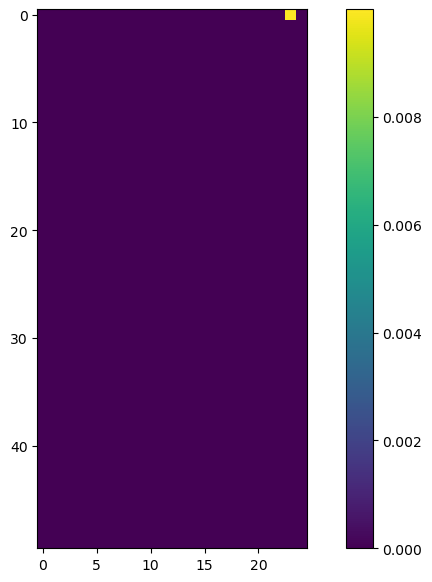

In [40]:
# Сохраняем в виде gif
make_2d_gif(density_z[0:1000,:,:], "test6_2d.gif", 10)